In [20]:
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import to_categorical # convert a matrix to 1s and 0s
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, regularizers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import schedules, Adam
from tensorflow import keras

**Data Preprocessing (5 marks)**

Load the dataset using TensorFlow Datasets.
Perform necessary preprocessing steps like resizing images, normalizing pixel values, etc.

I want to load the dataset, preprocess the images, and then I'll print out a few images to ensure that the dataset was loaded correctly. To do this I'll make a print images function to place inside the load and preprocess function.

In [21]:
def print_images(dataset, num_images=5):
    for image, label in dataset.take(num_images):
        plt.figure()
        plt.imshow(image)
        plt.title(f"Class: {label.numpy()}")
        plt.show()

I'm going to create the loading and pre processing function for the images here. This will include scaling, one-hot encoding for the labels, and standard scaler for the numerical values.

In [22]:
def load_and_preprocess_dataset(train_size, test_size):

    (train_dataset, test_dataset), dataset_info = tfds.load(
        'stanford_dogs',
        split=['train', 'test'],
        with_info=True,
        as_supervised=True,
        download=True
    )

    def preprocess(image, label):
        image = tf.image.resize(image, (28, 28))
        image = tf.cast(image, tf.float32) / 255.0 
        return image, label

    train_dataset = train_dataset.map(preprocess)
    test_dataset = test_dataset.map(preprocess)

    train_dataset = train_dataset.take(train_size)
    test_dataset = test_dataset.take(test_size)

    X_train, y_train = [], []
    for image, label in tfds.as_numpy(train_dataset):
        X_train.append(image)
        y_train.append(label)

    X_test, y_test = [], []
    for image, label in tfds.as_numpy(test_dataset):
        X_test.append(image)
        y_test.append(label)

    X_train = tf.reshape(X_train, [-1, 28 * 28 * 3])
    y_train = tf.reshape(y_train, [-1, 1])
    X_test = tf.reshape(X_test, [-1, 28 * 28 * 3])
    y_test = tf.reshape(y_test, [-1, 1])

    scale = StandardScaler()
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)

    OH = OneHotEncoder(categories='auto', sparse=False)
    y_train = OH.fit_transform(y_train)
    y_test = OH.transform(y_test)


    print_images(train_dataset, num_images=5)

    return X_train, X_test, y_train, y_test


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


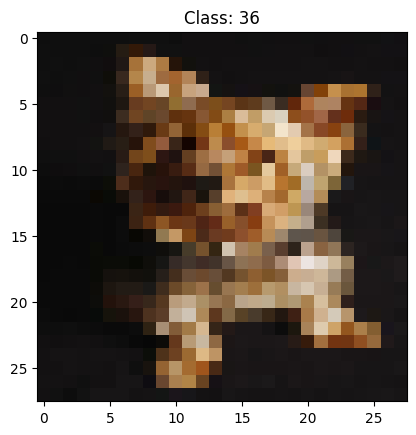

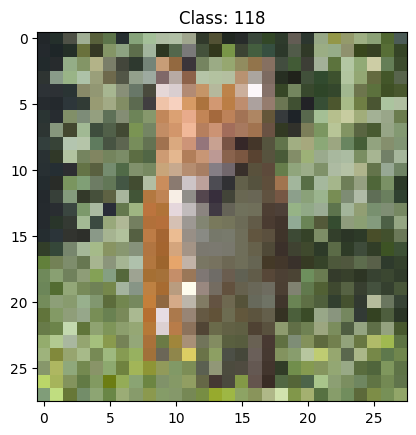

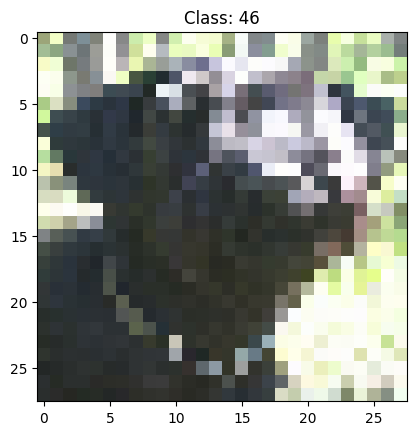

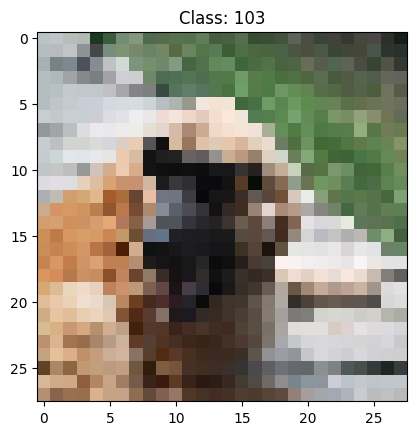

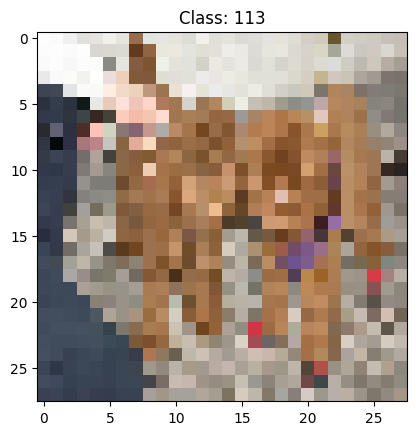

In [23]:
X_train, X_test, y_train, y_test = load_and_preprocess_dataset(12000, 8580)

In [24]:
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)
print('Min:', X_train.min())
print('Max:', X_train.max())

X_train: (12000, 2352)
y_train: (12000, 120)
X_test: (8580, 2352)
y_test: (8580, 120)
Min: -1.9982667623105923
Max: 2.5340386692272783


In [25]:
X_train = X_train.reshape(X_train.shape[0],28,28,3)
X_test = X_test.reshape(X_test.shape[0],28,28,3)

**Model Building (8 marks):**

Design a convolutional neural network (CNN) for this multi-class classification task.
Include various types of layers such as Convolutional Layers, Pooling Layers, Dropout Layers, and Fully Connected Layers.
Experiment with different numbers of layers and varying numbers of neurons.

In [26]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)


In [27]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/Users/mikeredshaw/Documents/Schulich MBAN/Data Science II/Assignment 3 - Image Classification/best_model.h5',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [28]:
custom_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(28,28,3)),#we're dealing w colored images so we need 3 channels, we're using 32 filters, 3x3 size (shape), then pick activation function (ReLU), then can use soft_max at the end (standard practice w reLu)
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), #don't have to specify input shape for 2nd layer, just first. This one can have bigger filter.
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), #most models will have 3 to 8 convolution layers
    tf.keras.layers.Flatten(), #should have at least one dense layer in your model.
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax') #this needs to have 120 layers because we have 120 categories. Adding the softmax at the end as mentioned before
])

In [29]:
custom_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 1152)             

**Model Training and Optimization (10 marks):**

Split the dataset into training, validation, and test sets.
Choose an appropriate loss function and optimizer for training the model.
Implement callbacks like Early Stopping and Model Checkpoints to optimize the training process.

I will begin trying with adam as the optimizer, and categorical_crossentropy, since each image belongs to a single class and there are multiple classes, thus this loss function makes the most sense.

In [30]:
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_model_history = custom_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping])

Epoch 1/50
188/188 [==============================] - 4s 18ms/step - loss: 4.6810 - accuracy: 0.0168 - val_loss: 4.4798 - val_accuracy: 0.0338
Epoch 2/50
188/188 [==============================] - 3s 17ms/step - loss: 4.3946 - accuracy: 0.0365 - val_loss: 4.3524 - val_accuracy: 0.0485
Epoch 3/50
188/188 [==============================] - 3s 17ms/step - loss: 4.2260 - accuracy: 0.0578 - val_loss: 4.2880 - val_accuracy: 0.0507
Epoch 4/50
188/188 [==============================] - 3s 17ms/step - loss: 4.0897 - accuracy: 0.0780 - val_loss: 4.2292 - val_accuracy: 0.0570
Epoch 5/50
188/188 [==============================] - 3s 18ms/step - loss: 3.9380 - accuracy: 0.1028 - val_loss: 4.2152 - val_accuracy: 0.0650
Epoch 6/50
188/188 [==============================] - 3s 17ms/step - loss: 3.7731 - accuracy: 0.1257 - val_loss: 4.2132 - val_accuracy: 0.0730
Epoch 7/50
188/188 [==============================] - 3s 17ms/step - loss: 3.6007 - accuracy: 0.1538 - val_loss: 4.2558 - val_accuracy: 0.0763

In [31]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])

In [32]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [33]:
model_1_history = model_1.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=18,
    callbacks=[early_stopping]
)

Epoch 1/50
667/667 [==============================] - 10s 15ms/step - loss: 4.7506 - accuracy: 0.0113 - val_loss: 4.6334 - val_accuracy: 0.0220
Epoch 2/50
667/667 [==============================] - 10s 14ms/step - loss: 4.4817 - accuracy: 0.0277 - val_loss: 4.4220 - val_accuracy: 0.0308
Epoch 3/50
667/667 [==============================] - 10s 15ms/step - loss: 4.2952 - accuracy: 0.0420 - val_loss: 4.2715 - val_accuracy: 0.0505
Epoch 4/50
667/667 [==============================] - 10s 15ms/step - loss: 4.1404 - accuracy: 0.0613 - val_loss: 4.1894 - val_accuracy: 0.0557
Epoch 5/50
667/667 [==============================] - 10s 15ms/step - loss: 3.9875 - accuracy: 0.0827 - val_loss: 4.2088 - val_accuracy: 0.0600
Epoch 6/50
667/667 [==============================] - 10s 15ms/step - loss: 3.8182 - accuracy: 0.1028 - val_loss: 4.1640 - val_accuracy: 0.0719
Epoch 7/50
667/667 [==============================] - 10s 15ms/step - loss: 3.6219 - accuracy: 0.1332 - val_loss: 4.1786 - val_accuracy:

I want to try some variations in the fitting to see if i can improve performance.

In [34]:
model_1_history = model_1.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/50
375/375 [==============================] - 8s 21ms/step - loss: 3.1361 - accuracy: 0.2257 - val_loss: 4.3898 - val_accuracy: 0.0875
Epoch 2/50
360/375 [===========================>..] - ETA: 0s - loss: 2.9368 - accuracy: 0.2641

KeyboardInterrupt: 

In [ ]:
model_1_history = model_1.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/50
188/188 [==============================] - 6s 32ms/step - loss: 2.4490 - accuracy: 0.3701 - val_loss: 4.6822 - val_accuracy: 0.0942
Epoch 2/50
188/188 [==============================] - 6s 31ms/step - loss: 2.2177 - accuracy: 0.4264 - val_loss: 4.8799 - val_accuracy: 0.0969
Epoch 3/50
188/188 [==============================] - 6s 31ms/step - loss: 1.9955 - accuracy: 0.4761 - val_loss: 5.2984 - val_accuracy: 0.0879
Epoch 4/50
188/188 [==============================] - 6s 32ms/step - loss: 1.7429 - accuracy: 0.5286 - val_loss: 5.6173 - val_accuracy: 0.0929
Epoch 5/50
188/188 [==============================] - 6s 32ms/step - loss: 1.4784 - accuracy: 0.5963 - val_loss: 6.0248 - val_accuracy: 0.0862
Epoch 6/50
188/188 [==============================] - 6s 31ms/step - loss: 1.2165 - accuracy: 0.6622 - val_loss: 6.5779 - val_accuracy: 0.0818
Epoch 7/50
188/188 [==============================] - 6s 32ms/step - loss: 0.9915 - accuracy: 0.7147 - val_loss: 7.4783 - val_accuracy: 0.0837

In [ ]:
model_1_history = model_1.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=16,
    callbacks=[early_stopping]
)

Epoch 1/50
750/750 [==============================] - 8s 11ms/step - loss: 1.6266 - accuracy: 0.5467 - val_loss: 6.0442 - val_accuracy: 0.0762
Epoch 2/50
750/750 [==============================] - 8s 11ms/step - loss: 1.3397 - accuracy: 0.6147 - val_loss: 6.7911 - val_accuracy: 0.0765
Epoch 3/50
750/750 [==============================] - 9s 12ms/step - loss: 1.1254 - accuracy: 0.6734 - val_loss: 7.7199 - val_accuracy: 0.0716
Epoch 4/50
750/750 [==============================] - 9s 11ms/step - loss: 0.9425 - accuracy: 0.7172 - val_loss: 8.4825 - val_accuracy: 0.0719
Epoch 5/50
750/750 [==============================] - 8s 11ms/step - loss: 0.7554 - accuracy: 0.7715 - val_loss: 9.0988 - val_accuracy: 0.0752
Epoch 6/50
750/750 [==============================] - 8s 11ms/step - loss: 0.6564 - accuracy: 0.8048 - val_loss: 9.6864 - val_accuracy: 0.0698
Epoch 7/50
750/750 [==============================] - 8s 11ms/step - loss: 0.5763 - accuracy: 0.8246 - val_loss: 10.5873 - val_accuracy: 0.071

Changing the batch size does have some impact, however, keeping it small will help with generalization, so since the differences aren't that impactful, I will keep the smaller 16 batch size model.

I'm going to try adding some additional layers, including dropout layers, to see how that may help the discrepency between accuracy and val_accuracy.

In [42]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation='softmax')
])

In [43]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_2_history = model_2.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/50
94/94 [==============================] - 3s 32ms/step - loss: 4.7821 - accuracy: 0.0105 - val_loss: 4.7315 - val_accuracy: 0.0210
Epoch 2/50
94/94 [==============================] - 3s 29ms/step - loss: 4.6665 - accuracy: 0.0208 - val_loss: 4.5526 - val_accuracy: 0.0267
Epoch 3/50
94/94 [==============================] - 3s 30ms/step - loss: 4.5398 - accuracy: 0.0275 - val_loss: 4.4614 - val_accuracy: 0.0311
Epoch 4/50
94/94 [==============================] - 3s 30ms/step - loss: 4.4676 - accuracy: 0.0298 - val_loss: 4.4158 - val_accuracy: 0.0428
Epoch 5/50
94/94 [==============================] - 3s 30ms/step - loss: 4.4022 - accuracy: 0.0342 - val_loss: 4.3379 - val_accuracy: 0.0467
Epoch 6/50
94/94 [==============================] - 3s 30ms/step - loss: 4.3475 - accuracy: 0.0419 - val_loss: 4.3087 - val_accuracy: 0.0519
Epoch 7/50
94/94 [==============================] - 3s 29ms/step - loss: 4.3010 - accuracy: 0.0489 - val_loss: 4.2610 - val_accuracy: 0.0573
Epoch 8/50
94

This model seemed to perform more consistently with the val data, however, it also failed to get above 10% on val_accuracy, with a much lower accuracy overall. I'll try making some more changes to the layers and see if I can make something better.

In [40]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])


In [41]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_3_history = model_3.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=128,
    callbacks=[early_stopping]
)

Epoch 1/50
94/94 [==============================] - 5s 51ms/step - loss: 4.6938 - accuracy: 0.0195 - val_loss: 4.5582 - val_accuracy: 0.0263
Epoch 2/50
94/94 [==============================] - 5s 51ms/step - loss: 4.4425 - accuracy: 0.0362 - val_loss: 4.4733 - val_accuracy: 0.0344
Epoch 3/50
94/94 [==============================] - 5s 53ms/step - loss: 4.2820 - accuracy: 0.0553 - val_loss: 4.3253 - val_accuracy: 0.0467
Epoch 4/50
94/94 [==============================] - 5s 51ms/step - loss: 4.1432 - accuracy: 0.0726 - val_loss: 4.3025 - val_accuracy: 0.0580
Epoch 5/50
94/94 [==============================] - 5s 49ms/step - loss: 3.9778 - accuracy: 0.0988 - val_loss: 4.2801 - val_accuracy: 0.0667
Epoch 6/50
94/94 [==============================] - 5s 49ms/step - loss: 3.8146 - accuracy: 0.1244 - val_loss: 4.3051 - val_accuracy: 0.0605
Epoch 7/50
94/94 [==============================] - 5s 51ms/step - loss: 3.6249 - accuracy: 0.1583 - val_loss: 4.3898 - val_accuracy: 0.0671
Epoch 8/50
94

Possibly adding learning rate and regularization may help.

In [35]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)

In [36]:
l2_regularization = 0.01

In [38]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax')
])

In [39]:
model_4.compile(optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_4_history = model_4.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=64
)

Epoch 1/10
188/188 [==============================] - 6s 31ms/step - loss: 4.7884 - accuracy: 0.0099 - val_loss: 4.7867 - val_accuracy: 0.0093
Epoch 2/10
188/188 [==============================] - 6s 31ms/step - loss: 4.7881 - accuracy: 0.0084 - val_loss: 4.7866 - val_accuracy: 0.0098
Epoch 3/10
188/188 [==============================] - 6s 31ms/step - loss: 4.7886 - accuracy: 0.0082 - val_loss: 4.7864 - val_accuracy: 0.0094
Epoch 4/10
188/188 [==============================] - 6s 30ms/step - loss: 4.7877 - accuracy: 0.0079 - val_loss: 4.7863 - val_accuracy: 0.0100
Epoch 5/10
188/188 [==============================] - 7s 35ms/step - loss: 4.7871 - accuracy: 0.0085 - val_loss: 4.7861 - val_accuracy: 0.0099
Epoch 6/10
188/188 [==============================] - 6s 33ms/step - loss: 4.7877 - accuracy: 0.0103 - val_loss: 4.7860 - val_accuracy: 0.0101
Epoch 7/10
188/188 [==============================] - 6s 32ms/step - loss: 4.7869 - accuracy: 0.0072 - val_loss: 4.7859 - val_accuracy: 0.0105

It appears that adam is the better optimizer approach compared to SGD with learning rate. No other loss function really makes sense for this type of problem, so I will continue with evaluating the best performing model, with all the variations, which was model_1.

**Evaluation (5 marks):**

Evaluate the model's performance on the test set.
Report the classification accuracy and visualize the performance using a confusion matrix.

In [44]:
test_loss, test_accuracy = model_1.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

269/269 [==============================] - 2s 6ms/step - loss: 4.4414 - accuracy: 0.0819
Test Loss: 4.441433429718018
Test Accuracy: 0.08193473517894745


The model did not perform well on the evaluation, which makes sense since it was relatively weak performing on the val_accuracy as well. Even though accuracy was okay (in the 70% range) it did not fit well on new data. To better review how it predicted in relation to the actual labels, I'll print out a confusion matrix.

In [45]:
y_pred = model_1.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)


print("Confusion Matrix (with class labels):")
print(conf_matrix)



269/269 [==============================] - 2s 6ms/step
Confusion Matrix (with class labels):
[[ 0  0  0 ...  0  0  0]
 [ 0 21  0 ...  1  0  0]
 [ 1  2  5 ...  0  0  1]
 ...
 [ 1  1  0 ...  9  4  1]
 [ 0  0  0 ...  2  9  0]
 [ 0  0  0 ...  0  2 15]]


I want to see the whole table. I'll print the full thing as a heat map to better review.

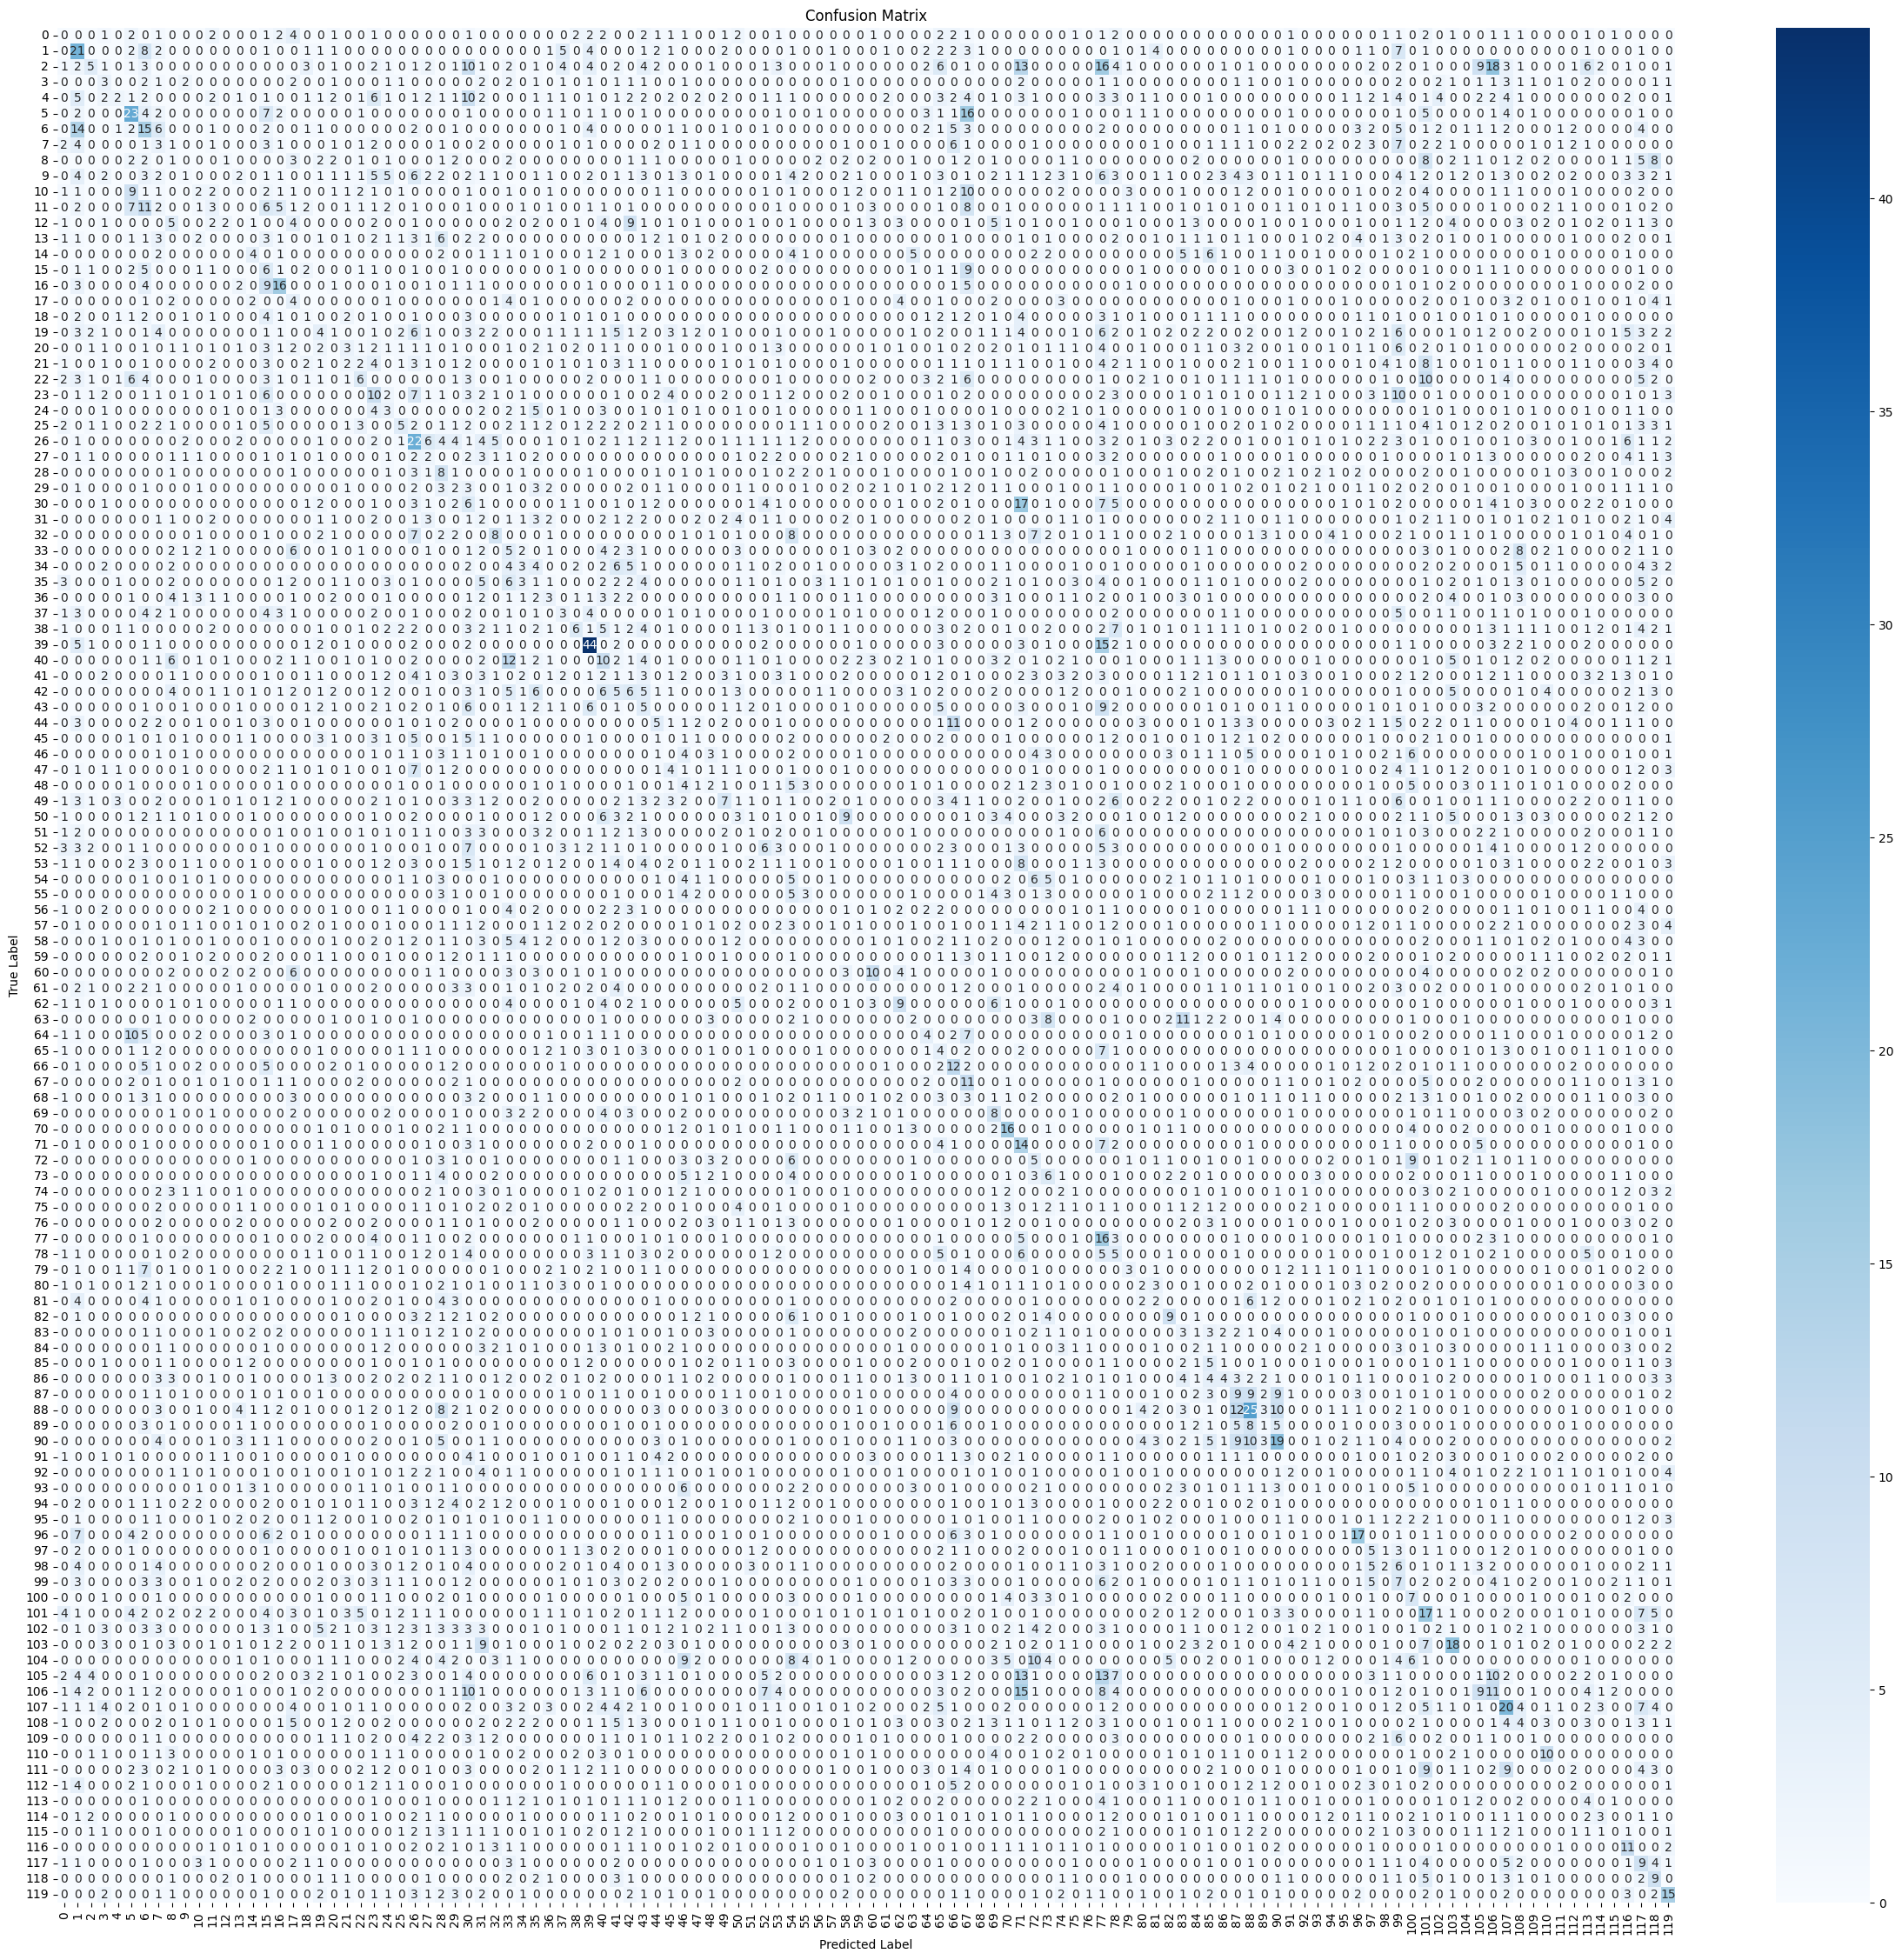

In [46]:
plt.figure(figsize=(30, 28))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(120), yticklabels=range(120))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Overall, it appears this model is relatively innaccurate, only predicting correctly about 6% of the time. Based on the confusion matrix, we can also see it's predictions per label are scattered all over the place, not really following the diagonal line that would indicate correct predictions. There are a few moments it does well (row 39 column 39 was correctly predicted 34 times), however for the most part it gets it wrong.

**Write-Up (2 marks):**

Document your process, model architecture choices, and results in a report.
Discuss any challenges faced and how you overcame them.
Provide insights on what worked well and what didn’t.

I decided to downscale the images to the 28*28 size to ensure that the models would run relatively quickly, and that the classification problem wouldn't require the extra detail. However, possibly not downscaling the images as much, and using more advanced models that require larger image sizes would help improve the classificastion of these images.

Some of the models performed well in accuracy, but they all performed poorly on validation accuracy. I attempted to overcome this by introducing regularization, dropout layers, new optimizers with learning rates, and variations in the layer layouts and filter sizes/numbers. None of this seemed to improve performance in any meaningful way. Because of this, I feel as though the downscaling to 28x28 may be the key issue.

Altering things like batch size did seem to have some effect, but keeping this lower to ensure the model is better at generalizing led to the best results in the final evaluation test. Overall, adam for optimizer, categorical_crossentropy for loss function, extra convolution layers (as many as I could fit without the downscaling being too much), and no dropout layers seemed to provide the best results.